## Fine-tuning to follow instructions

Instruction fine-tuning is one of the main techniques behind developing LLMs for
chatbot applications, personal assistants, and other conversational tasks.

## Preparing a dataset for supervised instruction fine-tunining

The dataset consists of 1,100 instruction–response pairs similar to those in. This dataset was created by Sebastian Rashka, but there are  alternative, publicly available instruction datasets in appendix B of his book.

In [1]:
import json 
import os 
import urllib
from IPython.display import Image
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

In [2]:
file_path = "instruction-data.json"

url = (
"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
"/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


Let’s print one of the entries to see how each entry is structured:

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


Based on the contents of this entry, the 'input' field may occasionally be empty:

Instruction fine-tuning involves training a model on a dataset where the input-output
pairs, like those we extracted from the JSON file, are explicitly provided. There are
various methods to format these entries for LLMs.

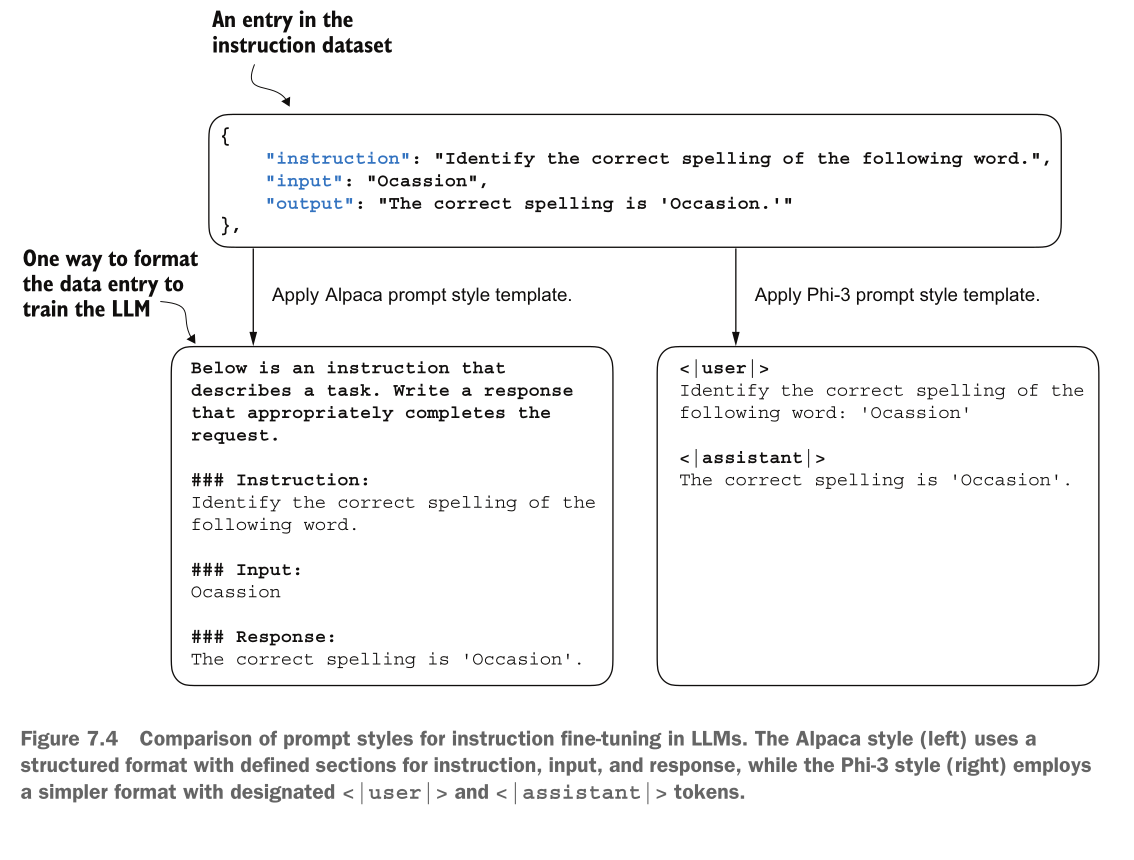

In [5]:
Image('./Screenshot from 2025-05-31 09-53-49.png')

Above we have two example formats reffered to as promp styles, used in the training of notable LLMs such as Alpaca and Phi-3. The rest of this chapter uses the Alpaca prompt style since it is one of the most
popular ones, largely because it helped define the original approach to fine-tuning.

Let’s define a format_input function that we can use to convert the entries in the
data list into the Alpaca-style input format.

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])

In [8]:
desired_response = f"\n\n### Response:\n{data[50]['output']}"

In [9]:
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


let’s divide the dataset into training, validation, and test sets

In [10]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

In the previous chapter, the training batches were created automatically by the PyTorch
DataLoader class, which employs a default collate function to combine lists of samples
into batches. A collate function is responsible for taking a list of individual data sam-
ples and merging them into a single batch that can be processed efficiently by the
model during training.

However, the batching process for instruction fine-tuning is a bit more involved and requires us to create our own custom collate function that we will later plug into the DataLoader. 

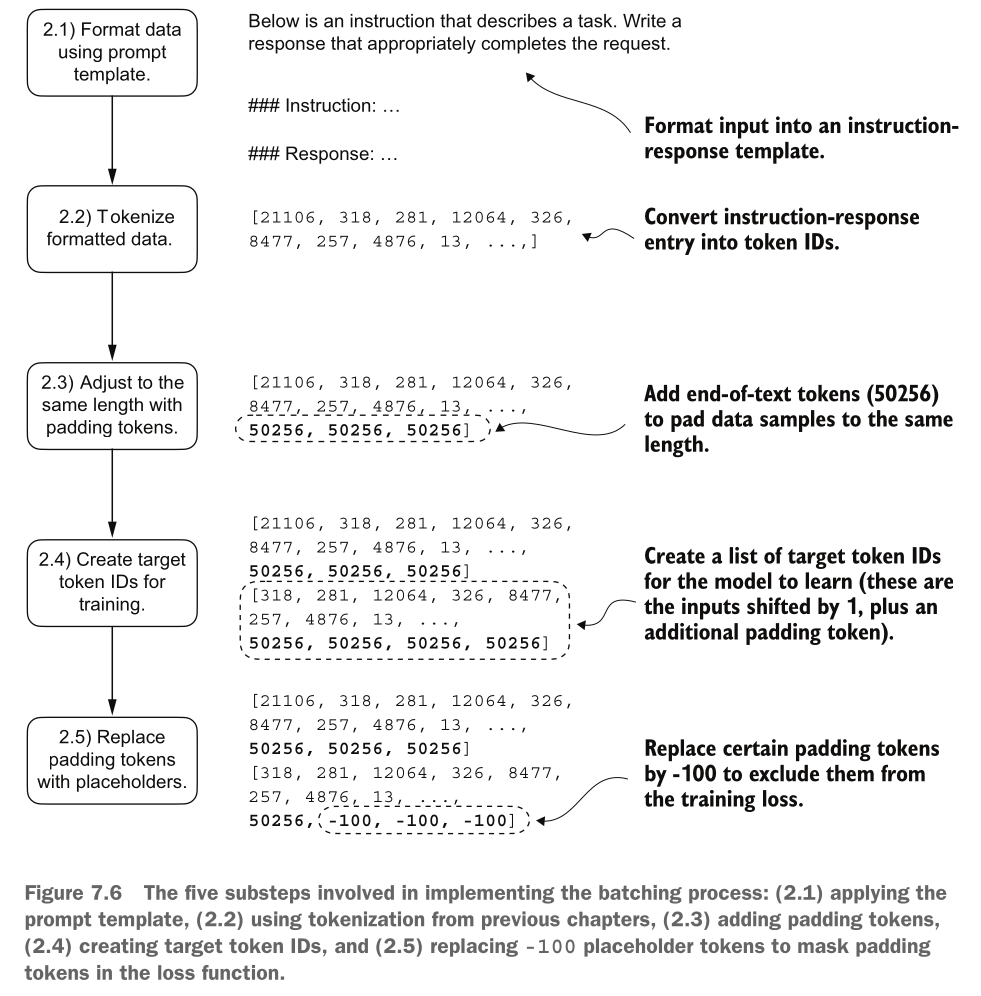

In [11]:
Image('./Screenshot from 2025-05-31 10-48-57.png')

Let's tackle the batching process in several steps, including coding the custom collate function. First to implement steps 2.1 and 2.2, we code an InstructionDataset class that applies format_input and pretokenizes all inputsin the dataset. This is done in the __init__ constructor. 

In [12]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

Similar to the approach for classification learning, we want to accelerate training by collecting multiple training examples in a batch, which neccesitates padding all inputs to a similar length. As with classification fine-tuning, we use he <|endoftext|>
token as a padding token.



Moving on to step 2.3 of the process, we adopt a more sophisticated approach by developing a custom collate function that we can pass to the data
loader. This custom collate function pads the training examples in each batch to the
same length while allowing different batches to have different lengths, This approach minimizes unnecessary padding by only extending
sequences to match the longest one in each batch, not the whole dataset.

In [13]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs) # Removes extra padded token added earlier

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


This output shows all inputs have been padded to the length of the longest input list,
inputs_1, containing five token IDs.

as we previously learned, we also need to create batches with the target token IDs corresponding to the batch of input IDs.

Similar to the process we used to pretrain an LLM, the target token IDs match the input token IDs but are shifted one position to the right. This setup allows the LLM to learn how to predict the next tokenin a sequence.The following updated collate function generates the target token IDs from the input token IDs:

In [15]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        inputs_lst.append(inputs) # Removes extra padded token added earlier
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In the next step, we assign -100 placeholder value to all padding tokens. This special value allows us to exclude these padding tokens
from contributing to the training loss calculation, ensuring that only meaningful data influences model learning. When fine-tuning for classification, we did not have to worry about this since we only trained the model based on the last output token.

However, note that we retain one end-of-text token, ID 50256, in the target list. Retaining it allows the LLM to learn when to generate an end-
of-text token in response to instructions, which we use as an indicator that the generated response is complete.

In the following listing, we modify our custom collate function to replace tokens
with ID 50256 with -100 in the target lists. Additionally, we introduce an allowed_max_length parameter to optionally limit the length of the samples. This adjustment will be useful if you plan to work with your own datasets that exceed the 1,024-token
context size supported by the GPT-2 model.

In [17]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100,allowed_max_length=None, device="cpu"):
    
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index


        # Optionally truncates to the maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[: allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs) # Removes extra padded token added earlier
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In addition to masking out padding tokens, it is also common to mask out the tar-
get token IDs that correspond to the instruction. By masking out the LLM’s target token IDs corresponding to the instruction, the cross
entropy loss is only computed for the generated response target IDs. Thus, the model
is trained to focus on generating accurate responses rather than memorizing instruc-
tions, which can help reduce overfitting. As of this writing, researchers are divided on whether masking the instructions is uni-
versally beneficial during instruction fine-tuning. We will not mask it.

## Creating data loaders for an instruction dataset

In [19]:
device =  "cpu"
print("Device:", device)

Device: cpu


Next, to reuse the chosen device setting in custom_collate_fn when we plug it
into the PyTorch DataLoader class, we use the partial function from Python’s
functools standard library to create a new version of the function with the device
argument prefilled. Additionally, we set the allowed_max_length to 1024, which trun-
cates the data to the maximum context length supported by the GPT-2 model, which
we will fine-tune later:

In [20]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

Next, we can set up the data loaders as we did previously, but this time, we will use our
custom collate function for the batching process.

In [21]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [22]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

## Loading a pretrained LLM

Before beginning instruction fine-tuning, we must first load a pretrained GPT
model that we want to fine-tune. However, instead of using the smallest 124-million-parameter model as before,
we load the medium-sized model with 355 million parameters. The reason for this
choice is that the 124-million-parameter model is too limited in capacity to achieve satisfactory results via instruction fine-tuning.

In [23]:
import sys
sys.path.append('../architecture/')  # or full path like '/home/user/project/my_module'
sys.path.append('../training/')  # or full path like '/home/user/project/my_module'


from gpt_download import download_and_load_gpt2
from gpt import GPTModel
from gpt_generate import load_weights_into_gpt

2025-05-31 21:23:50.082306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 21:23:50.090479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748741030.100384    6851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748741030.103423    6851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748741030.111223    6851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [24]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [25]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [26]:
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [27]:
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [28]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

## Fine-tuning the LLM on instruction data

For the fine-tuning process itself, we can reuse the loss calculation and
training functions implemented in chapter 5:

In [29]:
import sys
sys.path.append('../Classification_fine-tuning/')  # or full path like '/home/user/project/my_module'

from gpt_train import (calc_loss_loader, train_model_simple)
from gpt_train import text_to_token_ids


Before we begin training, let’s calculate the initial loss for the training and valida-
tion sets:

In [30]:
model.to(device)
torch.manual_seed(123)

In [31]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8258957386016847
Validation loss: 3.7619208812713625


In [32]:
# import time
# import torch

# # Start timer
# start_time = time.time()

# # Set random seed for reproducibility
# torch.manual_seed(123)

# # Define optimizer
# optimizer = torch.optim.AdamW(
#     model.parameters(),
#     lr=5e-5,
#     weight_decay=0.1
# )

# # Training configuration
# num_epochs = 2

# # Train the model
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model,
#     train_loader,
#     val_loader,
#     optimizer,
#     device,
#     num_epochs=num_epochs,
#     eval_freq=5,
#     eval_iter=5,
#     start_context=format_input(val_data[0]),
#     tokenizer=tokenizer
# )

# # End timer and print elapsed time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


## Extracting and saving responses

Having fine-tuned the LLM on the trainining portion of the instruction dataset, we are now ready to evaluate its performance on the held-out test set. First, we extract the model-generated responses for each input in the test dataset and collect them for
manual analysis, and then we evaluate the LLM to quantify the quality of the responses.

You can see that model evaluation is not as straightforward as it is for completion fine-tuning, where we can simply calculate the percentage of correct/non-spam class labels to obtain the classification accuracy. In practice instruction-fine-tuned LLMs such as chatbots are evaluated via multiple approaches:

Short-answer and multiple-choice benchmarks, such as Measuring Massive Multitask Language Understanding (MMLU; https://arxiv.org/abs/2009.03300), which test the general knowledge of a model.

Human preference comparison to other LLMs, such as LMSYS chatbot arena
(https://arena.lmsys.org).

Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval

In practice, it can be useful to consider all three types of evaluation methods: multiple-
choice question answering, human evaluation, and automated metrics that measure
conversational performance. However, since we are primarily interested in assessing con-
versational performance rather than just the ability to answer multiple-choice ques-
tions, human evaluation and automated metrics may be more relevant.


Human evaluation, while providing valuable insights, can be relatively laborious and
time-consuming, especially when dealing with a large number of responses. For
instance, reading and assigning ratings to all 1,100 responses would require a signifi-
cant amount of effort.
So, considering the scale of the task at hand, we will implement an approach simi-
lar to automated conversational benchmarks, which involves evaluating the responses
automatically using another LLM.

To prepare the responses for this evaluation process, we append the generated model responses to the test_set  dictionary and save the updated data as an "instruction-data-with-response.json" file for record keeping. Additionally, by saving this file, we can easily load and analyze the responses in separate Python sessions later on if needed.

In [33]:
# from tqdm import tqdm
# from gpt_generate import generate
# from gpt_generate import text_to_token_ids, token_ids_to_text\

# for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
#     input_text = format_input(entry)

#     token_ids = generate(
#         model=model,
#         idx=text_to_token_ids(input_text, tokenizer).to(device),
#         max_new_tokens=256,
#         context_size=BASE_CONFIG["context_length"],
#         eos_id=50256
#     )


#     generated_text = token_ids_to_text(token_ids, tokenizer)  

#     response_text = (
#         generated_text[len(input_text):].replace("### Response:", "").strip()
#     )

#     test_data[i]["model_response"] = response_text
    
# with open("instruction-data-with-response.json", "w") as file:
#     json.dump(test_data, file, indent=4)


In [34]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.'}


Finally, we save the model as gpt2-medium355M-sft.pth file to be able to reuse it in
future projects:

In [53]:
import re 
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth" # Removes white spaces and parentheses from file name
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")


Model saved as gpt2-medium355M-sft.pth


In [37]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

<All keys matched successfully>

## Evaluating the fine-tuned LLM

To evaluate test set responses in an automated fashion, we utilize an existing
instruction-fine-tuned 8-billion-parameter Llama 3 model developed by Meta AI. This
model can be run locally using the open source Ollama application. The following code verifies that the Ollama session is running properly before we
use Ollama to evaluate the test set responses:

In [38]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running 

In [39]:
ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


 An alternative to the ollama run command for interacting with the model is through
its REST API using Python. The query_model function shown in the following listing
demonstrates how to use the API.

In [41]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:10500/api/chat"
):
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {"seed":123, "temperature":0, "num_ctx": 2048}
    }

    # Converts the dictionary to a JSON-formatted string andencodes it to bytes

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url,data=payload,method="POST")
    request.add_header("Content-Type", "application/json")
    
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data
    

In [42]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in many llama diets.
3. Grains: Oats, barley, and corn are common grains that llamas enjoy.
4. Fruits and vegetables: Llamas may also eat fruits like apples, carrots, and sweet potatoes, as well as leafy greens like kale and spinach.
5. Minerals: Llamas need access to minerals like calcium, phosphorus, and salt to maintain strong bones and overall health.

In the wild, llamas might forage on:

* Leaves from trees and shrubs
* Bark from certain tree species
* Mosses and lichens
* Wild grasses and plants

Domesticated llamas, which are often kept as pets or used for fiber production, typically receive a diet that is carefully managed by their owners. This may include a mix of hay, grains, and s

Using the query_model function defined earlier, we can evaluate the responses generated by our fine-tuned model that prompts the Llama 3 model to rate our finetuned model’s responses on a scale from 0 to 100 based on the given test set
response as reference.

In [46]:
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores
    

In [51]:
def load_test_data(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

test_data = load_test_data('./instruction-data-with-response.json')

In [52]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [00:14<00:00,  7.51it/s]

Number of scores: 110 of 110
Average score: 47.85



To further improve our model’s performance, we can explore various strategies,
such as:

Adjusting the hyperparameters during fine-tuning, such as the learning rate, batch size, or number of epochs

Increasing the size of the training dataset or diversifying the examples to cover
a broader range of topics and styles

Experimenting with different prompts or instruction formats to guide the
model’s responses more effectively

Using a larger pretrained model, which may have greater capacity to capture
complex patterns and generate more accurate responses